In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Specify the file path in Google Drive
file_path = '/content/drive/MyDrive/Diss/roberta xlnet/combined_results.csv'

# Read the CSV file into a Data
df = pd.read_csv(file_path)


In [ ]:
# referenced and modified - https://huggingface.co/docs/transformers/model_doc/xlnet
# https://github.com/shanayghag/Sentiment-classification-using-XLNet
# https://medium.com/swlh/using-xlnet-for-sentiment-classification-cfa948e65e85

In [3]:
!pip install ktrain
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 65.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 48.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.39.0-py3-none-any.whl size=25319737 sha256=90dbe561446131cd90b9fc51a41759dc5033c2c2734fe21d5f4d69aa7802c87a
  Stored in directory: /root/.cache/pip/wheels/98/fd/0a/ef6252223f3d2c

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ktrain
from ktrain import text
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import timeit
import warnings


In [5]:
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame
train_df, test_temp_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(test_temp_df, test_size=0.5, random_state=42)

# Print the lengths of the training, validation, and test sets
print(len(train_df), len(validate_df), len(test_df))


49008 6126 6127


In [6]:
# Print the column names of the DataFrame
print(train_df.columns)


Index(['Publication Date', 'Source', 'URL', 'Title', 'Summary', 'Categories',
       'Industries', 'Organisations', 'People', 'Locations', 'Other Entities',
       'News topic', 'Title_Emotion', 'Title_Emotion_Score', 'Summary_Emotion',
       'Summary_Emotion_Score'],
      dtype='object')


In [7]:
print("\nTrain Dataset Features for Emotion: \n", train_df['Title_Emotion'], train_df['Summary_Emotion'])
print("\nValidation Dataset Features for Emotion: \n", validate_df['Title_Emotion'], validate_df['Summary_Emotion'])
print("\nTest Dataset Features for Emotion: \n", test_df['Title_Emotion'], test_df['Summary_Emotion'])



Train Dataset Features for Emotion: 
 24947      anger
15397       fear
53897    neutral
29151    neutral
11878       fear
          ...   
54343    neutral
38158    neutral
860      neutral
15795    neutral
56422    neutral
Name: Title_Emotion, Length: 49008, dtype: object 24947    neutral
15397       fear
53897    neutral
29151    neutral
11878       fear
          ...   
54343    neutral
38158    neutral
860      neutral
15795       fear
56422      anger
Name: Summary_Emotion, Length: 49008, dtype: object

Validation Dataset Features for Emotion: 
 41540    neutral
3933       anger
8188         joy
51402    neutral
30961    disgust
          ...   
40552    sadness
42762        joy
27554    neutral
17523       fear
54201    sadness
Name: Title_Emotion, Length: 6126, dtype: object 41540      anger
3933       anger
8188     disgust
51402      anger
30961       fear
          ...   
40552    sadness
42762    neutral
27554    neutral
17523      anger
54201      anger
Name: Summary_Emot

In [8]:
train_df.isnull().sum()

Publication Date             0
Source                       0
URL                          0
Title                        0
Summary                      0
Categories                   0
Industries               36475
Organisations             2424
People                   49008
Locations                 9446
Other Entities            6919
News topic                   0
Title_Emotion                0
Title_Emotion_Score          0
Summary_Emotion              0
Summary_Emotion_Score        0
dtype: int64

In [9]:
train_df.groupby("Title_Emotion").describe()


People                              Title_Emotion_Score  \
               count mean std min 25% 50% 75% max               count   
Title_Emotion                                                           
anger            0.0  NaN NaN NaN NaN NaN NaN NaN              8805.0   
disgust          0.0  NaN NaN NaN NaN NaN NaN NaN              2250.0   
fear             0.0  NaN NaN NaN NaN NaN NaN NaN              6643.0   
joy              0.0  NaN NaN NaN NaN NaN NaN NaN              2414.0   
neutral          0.0  NaN NaN NaN NaN NaN NaN NaN             20252.0   
sadness          0.0  NaN NaN NaN NaN NaN NaN NaN              7589.0   
surprise         0.0  NaN NaN NaN NaN NaN NaN NaN              1055.0   

                         ...                     Summary_Emotion_Score  \
                   mean  ...       75%       max                 count   
Title_Emotion            ...                                             
anger          0.638294  ...  0.801014  0.994372                8805.0   
disgust        0.582623  ...  0.722655  0.990879                2250.0   
fear           0.676201  ...  0.874926  0.993994                6643.0   
joy            0.649322  ...  0.811453  0.991314                2414.0   
neutral        0.671263  ...  0.825842  0.971847               20252.0   
sadness        0.652612  ...  0.820345  0.988713                7589.0   
surprise       0.575903  ...  0.696627  0.985017                1055.0   

                                                                           \
                   mean       std       min       25%       50%       75%   
Title_Emotion                                                               
anger          0.625112  0.188407  0.210544  0.471813  0.607852  0.778865   
disgust        0.607853  0.187437  0.240189  0.450891  0.589458  0.752173   
fear           0.664753  0.196786  0.220774  0.497283  0.666276  0.839411   
joy            0.652473  0.184828  0.232325  0.499124  0.646057  0.806322   
neutral        0.642650  0.188004  0.209465  0.485063  0.640079  0.807036   
sadness        0.603969  0.190852  0.223793  0.444384  0.580802  0.756821   
surprise       0.638780  0.189967  0.229487  0.477272  0.638912  0.800787   

                         
                    max  
Title_Emotion            
anger          0.992852  
disgust        0.990444  
fear           0.993827  
joy            0.988273  
neutral        0.991566  
sadness        0.993005  
surprise       0.987326  

[7 rows x 24 columns]

In [10]:
train_df.groupby("Summary_Emotion").describe()

People                              Title_Emotion_Score  \
                 count mean std min 25% 50% 75% max               count   
Summary_Emotion                                                           
anger              0.0  NaN NaN NaN NaN NaN NaN NaN             10352.0   
disgust            0.0  NaN NaN NaN NaN NaN NaN NaN              2549.0   
fear               0.0  NaN NaN NaN NaN NaN NaN NaN             12064.0   
joy                0.0  NaN NaN NaN NaN NaN NaN NaN              2539.0   
neutral            0.0  NaN NaN NaN NaN NaN NaN NaN             16268.0   
sadness            0.0  NaN NaN NaN NaN NaN NaN NaN              4532.0   
surprise           0.0  NaN NaN NaN NaN NaN NaN NaN               704.0   

                           ...                     Summary_Emotion_Score  \
                     mean  ...       75%       max                 count   
Summary_Emotion            ...                                             
anger            0.636886  ...  0.794503  0.994372               10352.0   
disgust          0.626267  ...  0.788915  0.994253                2549.0   
fear             0.659654  ...  0.834169  0.993146               12064.0   
joy              0.675841  ...  0.834916  0.991314                2539.0   
neutral          0.663411  ...  0.822586  0.992963               16268.0   
sadness          0.665378  ...  0.838886  0.991857                4532.0   
surprise         0.673183  ...  0.834148  0.993994                 704.0   

                                                                             \
                     mean       std       min       25%       50%       75%   
Summary_Emotion                                                               
anger            0.609905  0.185193  0.220774  0.458864  0.590732  0.754988   
disgust          0.548566  0.172197  0.231261  0.415221  0.516332  0.671257   
fear             0.658257  0.197872  0.223846  0.489666  0.652158  0.835840   
joy              0.664789  0.182813  0.209465  0.513130  0.666024  0.821119   
neutral          0.646109  0.182176  0.211880  0.496501  0.650007  0.804585   
sadness          0.623188  0.200877  0.210544  0.449228  0.605630  0.796014   
surprise         0.651777  0.211541  0.229487  0.460288  0.652561  0.843880   

                           
                      max  
Summary_Emotion            
anger            0.992852  
disgust          0.988051  
fear             0.993827  
joy              0.988184  
neutral          0.973737  
sadness          0.989827  
surprise         0.981943  

[7 rows x 24 columns]

In [11]:
label_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

In [12]:
train_df["title_text_length"] = train_df["Title"].apply(len)
train_df.head()

,Publication Date,Source,URL,Title,Summary,Categories,Industries,Organisations,People,Locations,Other Entities,News topic,Title_Emotion,Title_Emotion_Score,Summary_Emotion,Summary_Emotion_Score,title_text_length
24947,2023-08-25T23:38:59+0000,Horadeopinion,https://horadeopinion.com.ar/la-cancion-de-pro...,The protest song of an unknown Virginia farmer...,"En apenas un par de semanas, «Rich Men North o...","Arts & Entertainment\nMusic\narts, culture and...",Information and Media\nMusic Business,Virginia\nUnited States\nSpotify\nYouTube\nRic...,NaN,Virginia\nUnited States,Oliver Anthony\nTaylor Swift\nMorgan Wallen,rich men north of richmond,anger,0.974479,neutral,0.704851,80
15397,2023-05-04T11:46:27+0000,Newsweek,https://www.newsweek.com/police-silence-former...,Who Killed Jordan Neely? Police Silence Over F...,Questions have been raised about the New York ...,Teens\nSociety\nhomicide,Government and Nonprofits\nGovernment Services...,United States Marine Corps\nNew York City Poli...,NaN,Manhattan,Jordan Neely\nMatthew M. Neely\nBlack,killing of jordan neely,fear,0.405922,fear,0.474702,75
53897,2023-05-30T08:49:47+0000,Nature,https://www.nature.com/articles/s41423-023-010...,Macrophage phagocytosis of SARS-CoV-2-infected...,SARS-CoV-2 nucleocapsid is detected in MDMs up...,Arthritis\nHealth & Fitness\ndisease\nHealth a...,NaN,Muttahida Majlis-e-Amal,NaN,NaN,Severe acute respiratory syndrome coronavirus ...,proximal origin SARS-CoV-2,neutral,0.786192,neutral,0.903202,107
29151,2022-12-14T23:38:20+0000,MSN News Canada,https://www.msn.com/en-ca/news/other/trump-spe...,Trump special counsel Jack Smith lost the John...,A ttorney General Merrick Garland's appointmen...,"Commentary\nLaw, Gov’t & Politics\njudiciary (...",NaN,United States Department of Justice,NaN,"Smith County, Texas",Jack Smith (film director)\nJohn Edwards\nDona...,jack smith special counsel investigation,neutral,0.629142,neutral,0.560315,83
11878,2023-03-27T12:36:27+0000,Daily Caller,https://dailycaller.com/2023/03/27/army-jonath...,Army Halts Multi-Million Dollar Ad Campaign Af...,The U.S. Army halted a multi-million dollar ad...,"Local News\nU.S. Government Resources\nLaw, Go...",NaN,Army\nThe U.S. Army\nThe Military Times\nUnite...,NaN,NaN,Halts Multi-Million\nJonathan Majors Arrested\...,jonathan majors assault allegations (1),fear,0.316275,fear,0.768027,112


In [13]:
train_df["Summary_text_length"] = train_df["Summary"].apply(len)
train_df.head()

,Publication Date,Source,URL,Title,Summary,Categories,Industries,Organisations,People,Locations,Other Entities,News topic,Title_Emotion,Title_Emotion_Score,Summary_Emotion,Summary_Emotion_Score,title_text_length,Summary_text_length
24947,2023-08-25T23:38:59+0000,Horadeopinion,https://horadeopinion.com.ar/la-cancion-de-pro...,The protest song of an unknown Virginia farmer...,"En apenas un par de semanas, «Rich Men North o...","Arts & Entertainment\nMusic\narts, culture and...",Information and Media\nMusic Business,Virginia\nUnited States\nSpotify\nYouTube\nRic...,NaN,Virginia\nUnited States,Oliver Anthony\nTaylor Swift\nMorgan Wallen,rich men north of richmond,anger,0.974479,neutral,0.704851,80,1132
15397,2023-05-04T11:46:27+0000,Newsweek,https://www.newsweek.com/police-silence-former...,Who Killed Jordan Neely? Police Silence Over F...,Questions have been raised about the New York ...,Teens\nSociety\nhomicide,Government and Nonprofits\nGovernment Services...,United States Marine Corps\nNew York City Poli...,NaN,Manhattan,Jordan Neely\nMatthew M. Neely\nBlack,killing of jordan neely,fear,0.405922,fear,0.474702,75,1133
53897,2023-05-30T08:49:47+0000,Nature,https://www.nature.com/articles/s41423-023-010...,Macrophage phagocytosis of SARS-CoV-2-infected...,SARS-CoV-2 nucleocapsid is detected in MDMs up...,Arthritis\nHealth & Fitness\ndisease\nHealth a...,NaN,Muttahida Majlis-e-Amal,NaN,NaN,Severe acute respiratory syndrome coronavirus ...,proximal origin SARS-CoV-2,neutral,0.786192,neutral,0.903202,107,1314
29151,2022-12-14T23:38:20+0000,MSN News Canada,https://www.msn.com/en-ca/news/other/trump-spe...,Trump special counsel Jack Smith lost the John...,A ttorney General Merrick Garland's appointmen...,"Commentary\nLaw, Gov’t & Politics\njudiciary (...",NaN,United States Department of Justice,NaN,"Smith County, Texas",Jack Smith (film director)\nJohn Edwards\nDona...,jack smith special counsel investigation,neutral,0.629142,neutral,0.560315,83,1649
11878,2023-03-27T12:36:27+0000,Daily Caller,https://dailycaller.com/2023/03/27/army-jonath...,Army Halts Multi-Million Dollar Ad Campaign Af...,The U.S. Army halted a multi-million dollar ad...,"Local News\nU.S. Government Resources\nLaw, Go...",NaN,Army\nThe U.S. Army\nThe Military Times\nUnite...,NaN,NaN,Halts Multi-Million\nJonathan Majors Arrested\...,jonathan majors assault allegations (1),fear,0.316275,fear,0.768027,112,1261


<Axes: ylabel='Frequency'>

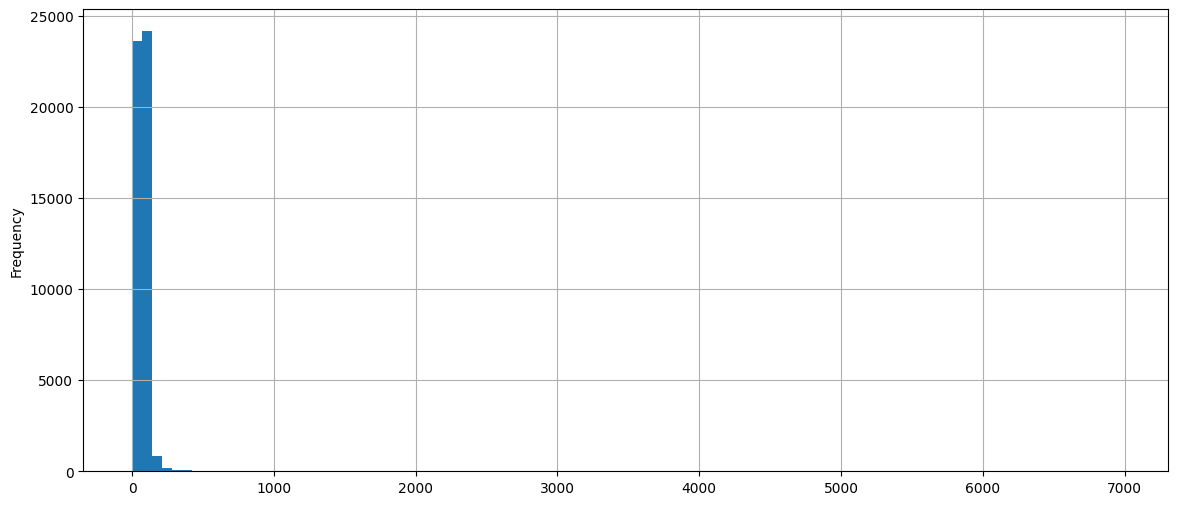

In [12]:
plt.figure(figsize=(14,6))
train_df["title_text_length"].plot.hist(bins=100, grid=True)

<Axes: ylabel='Frequency'>

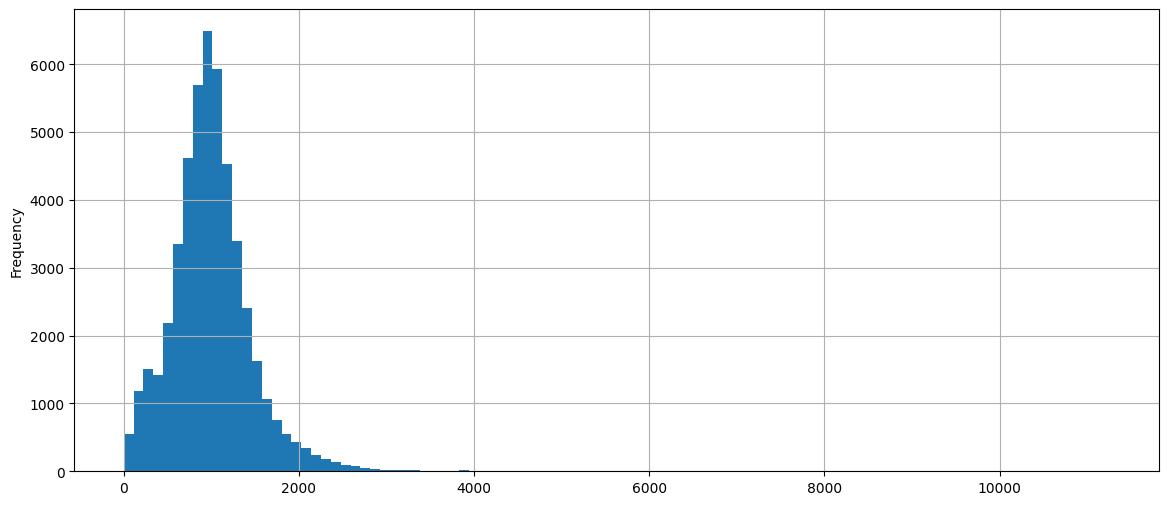

In [13]:
plt.figure(figsize=(14,6))
train_df["Summary_text_length"].plot.hist(bins=100, grid=True)

array([[<Axes: title={'center': 'anger'}>,
        <Axes: title={'center': 'disgust'}>,
        <Axes: title={'center': 'fear'}>],
       [<Axes: title={'center': 'joy'}>,
        <Axes: title={'center': 'neutral'}>,
        <Axes: title={'center': 'sadness'}>],
       [<Axes: title={'center': 'surprise'}>, <Axes: >, <Axes: >]],
      dtype=object)

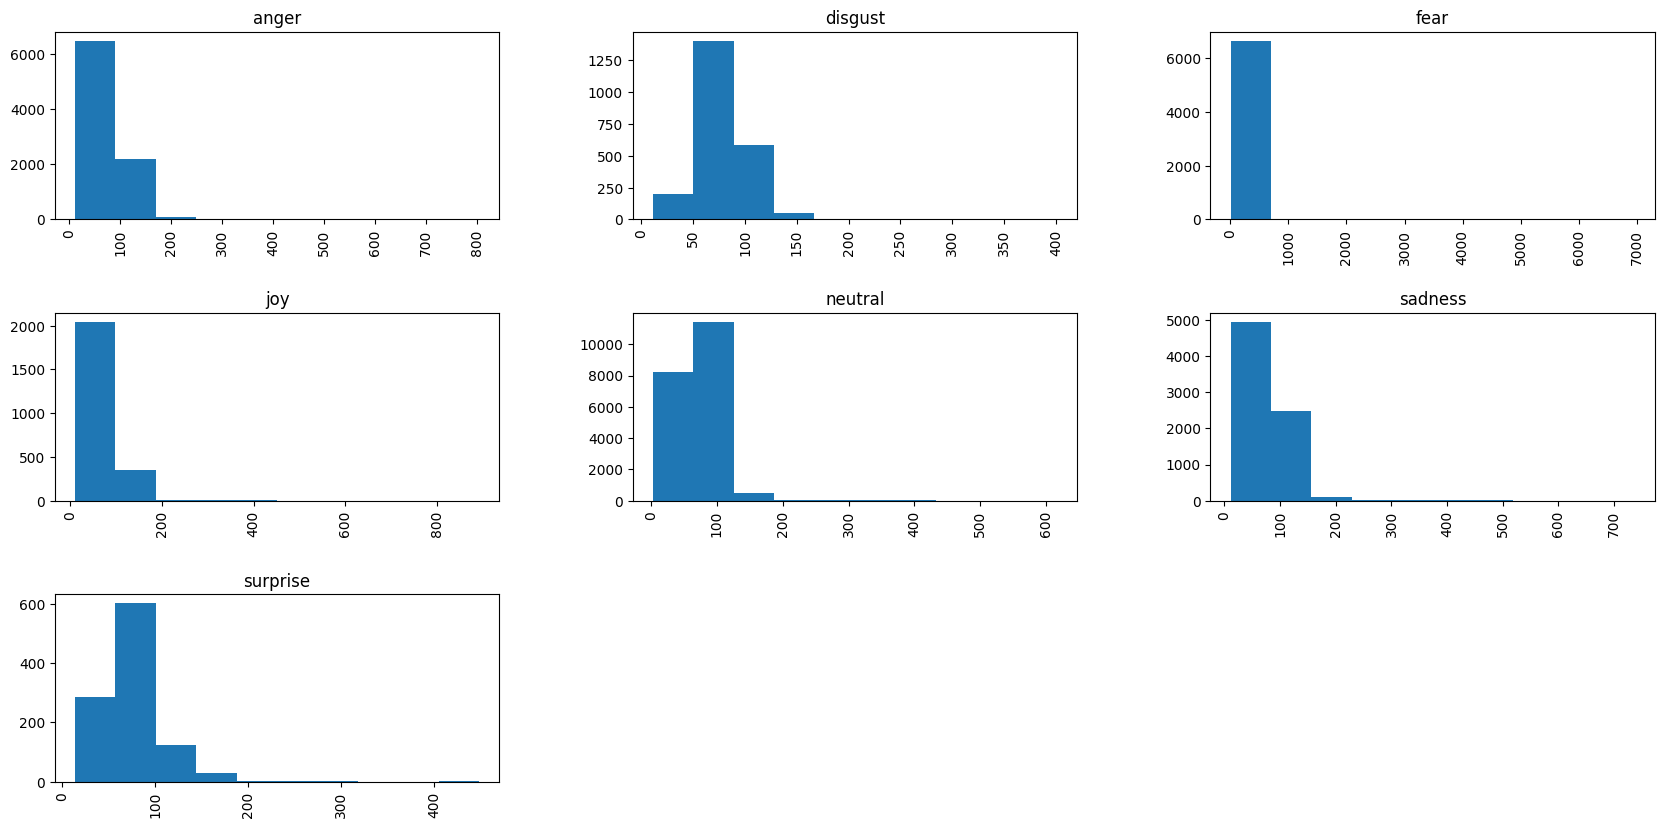

In [14]:
train_df.hist(column="title_text_length", by="Title_Emotion", figsize=(20,10), grid=True)

array([[<Axes: title={'center': 'anger'}>,
        <Axes: title={'center': 'disgust'}>,
        <Axes: title={'center': 'fear'}>],
       [<Axes: title={'center': 'joy'}>,
        <Axes: title={'center': 'neutral'}>,
        <Axes: title={'center': 'sadness'}>],
       [<Axes: title={'center': 'surprise'}>, <Axes: >, <Axes: >]],
      dtype=object)

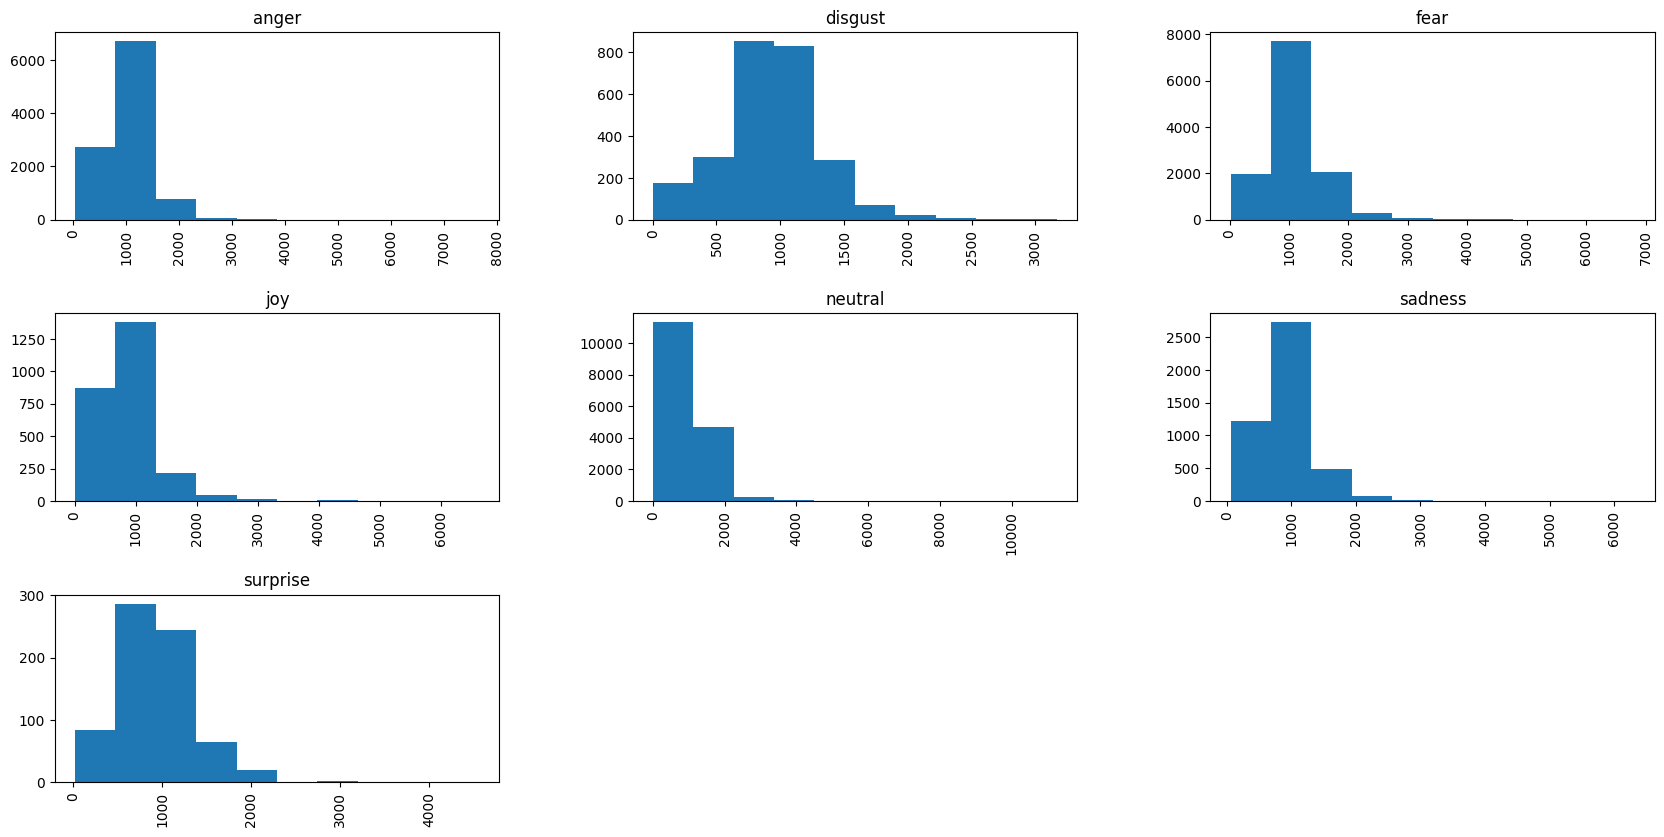

In [15]:
train_df.hist(column="Summary_text_length", by="Summary_Emotion", figsize=(20,10), grid=True)

In [16]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Nov 30 20:32:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 54.8 gigabytes of available RAM



In [18]:
!pip install ktrain
!pip install transformers


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ktrain
from ktrain import text
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import timeit
import warnings



In [20]:
xlnet_transformer = text.Transformer('xlnet-base-cased', maxlen=512, classes = label_names, batch_size=7)

/usr/local/lib/python3.10/dist-packages/ktrain/text/preprocessor.py:382: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/565M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [22]:
X_train = train_df[:]["Summary"]
y_train = train_df[:]["Summary_Emotion"]
X_test = validate_df[:]["Summary"]
y_test = validate_df[:]["Summary_Emotion"]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(49008,) (49008,) (6126,) (6126,)


In [23]:
xlnet_train = xlnet_transformer.preprocess_train(X_train.to_list(), y_train.to_list())
xlnet_val = xlnet_transformer.preprocess_test(X_test.to_list(), y_test.to_list())

preprocessing train...
language: en
train sequence lengths:
	mean : 157
	95percentile : 268
	99percentile : 367


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 155
	95percentile : 268
	99percentile : 364


In [24]:
xlnet_model = xlnet_transformer.get_classifier()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [25]:
xlnet_learner_ins = ktrain.get_learner(model=xlnet_model,
                            train_data=xlnet_train,
                            val_data=xlnet_val,
                            batch_size=7)

In [26]:
xlnet_learner_ins.model.summary()

Model: "tfxl_net_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFXLNetMainLa  multiple                  116718336 
 yer)                                                            
                                                                 
 sequence_summary (TFSequen  multiple                  590592    
 ceSummary)                                                      
                                                                 
 logits_proj (Dense)         multiple                  5383      
                                                                 
Total params: 117314311 (447.52 MB)
Trainable params: 117314311 (447.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


simulating training for different learning rates... this may take a few moments...
Epoch 1/3
7001/7001 [==============================] - 4286s 608ms/step - loss: 1.2955 - accuracy: 0.5021
Epoch 2/3
7001/7001 [==============================] - 4264s 609ms/step - loss: 2.0788 - accuracy: 0.3478
Epoch 3/3
7001/7001 [==============================] - 14s 2ms/step - loss: 13.2342 - accuracy: 0.1930


done.
Visually inspect loss plot and select learning rate associated with falling loss


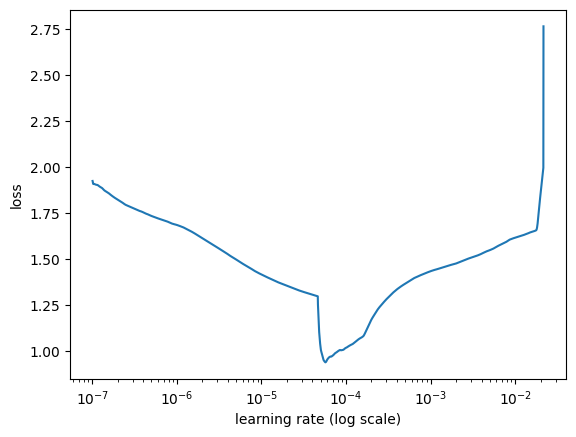


Total time in minutes on estimating optimal learning rate: 
 142.83011220880002


In [27]:
rate_finder_start_time = timeit.default_timer()
xlnet_learner_ins.lr_find(show_plot=True, max_epochs=3)
rate_finder_stop_time = timeit.default_timer()

print("\nTotal time in minutes on estimating optimal learning rate: \n", (rate_finder_stop_time - rate_finder_start_time)/60)

In [29]:
xlnet_fine_tune_start_time = timeit.default_timer()
xlnet_learner_ins.fit_onecycle(lr=8e-5, epochs=3)
xlnet_fine_tune_stop_time = timeit.default_timer()

print("\nTotal time in minutes for Fine-Tuning XLNet on Emotion Dataset: \n", (xlnet_fine_tune_stop_time - xlnet_fine_tune_start_time)/60)



begin training using onecycle policy with max lr of 8e-05...
Epoch 1/3
7002/7002 [==============================] - 4449s 634ms/step - loss: 0.8770 - accuracy: 0.6742 - val_loss: 0.8096 - val_accuracy: 0.6938
Epoch 2/3
7002/7002 [==============================] - 4421s 631ms/step - loss: 0.8419 - accuracy: 0.6933 - val_loss: 0.8091 - val_accuracy: 0.7058
Epoch 3/3
7002/7002 [==============================] - 4421s 631ms/step - loss: 0.5322 - accuracy: 0.8097 - val_loss: 0.7043 - val_accuracy: 0.7481

Total time in minutes for Fine-Tuning XLNet on Emotion Dataset: 
 221.51261208428335


In [31]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification

# Assuming xlnet_learner_ins is your fine-tuned RoBERTa model
xlnet_model = xlnet_learner_ins.model

# Save the fine-tuned model
xlnet_model.save_pretrained('/content/drive/MyDrive/Diss/roberta xlnet/xlnet model/')
